# Task 2a: Active Learning for SAT Solving -- Demo of Timeout Oracle


In this notebook, we combine `scikit-activeml` with a query timeout, i.e.,
label queries to the oracle may be interrupted (to save costs) but return no actual label in that case
(so one needs to decide how to deal with these instances for future model trainings).
We have implemented such an oracle in a separate module.

We start by loading the data and splitting it into features/target and train/test.
The latter functionality is integrated into our custom oracle.
The target can either be

- the satisfiability result or
- whether a particular solver times out.

Unless you adapt `TARGET` below, we predict the timeout behavior of the solver winning the 2022 SAT Competition's Anniversary Track.
With the satisfiability result as target, the oracle also determines query cost based on the runtimes of this particular solver,
and the data split excludes instances with timeouts in the competition
(since the solver could not have determined satisfiability if it ran into a timeout).

All targets lead to a binary-classification scenario (as also assumed when creating the `clf_model` below).
The true class labels are hidden from the user, i.e., only the feature-part of the data is returned
(but the oracle has a method for scoring predictions provided by the user).

In [1]:
import pandas as pd
import sklearn.model_selection
import sklearn.preprocessing

import al_oracle

TARGET = al_oracle.DEFAULT_SOLVER  # can be "result" or any of the "runtimes." columns 

oracle = al_oracle.ALOracle()
dataset = pd.read_csv('data/dataset.csv')
X_train, X_test = oracle.split_data(dataset=dataset, target=TARGET, random_state=25)

Next, we create our prediction model, like in the other (timeout-unaware) notebook `Active_Learning_Demo.ipynb`.
The package `scikit-activeml` provides a few models on its own but also allows to wrap `scikit-learn` models.
The wrapper is necessary to handle missing (default-value) class labels of unlabeled instances.

In [2]:
import skactiveml.classifier
import sklearn.tree

clf_model = skactiveml.classifier.SklearnClassifier(
    estimator=sklearn.tree.DecisionTreeClassifier(random_state=25),
    classes=(0, 1),
    random_state=25
)

The query strategy determines in which order the points are labeled.
`scikit-activeml` provides multiple such strategies; we compare two simple ones,
like in `Active_Learning_Demo.ipynb`.

In [3]:
import skactiveml.pool

QUERY_STRATEGIES = {
    'Random': skactiveml.pool.RandomSampling(random_state=25),
    'Uncertainty-Entropy': skactiveml.pool.UncertaintySampling(method='entropy', random_state=25)
}

We now run these two query strategies.
The batch size determines how many points are queried at once.

Also, we need to decide which query timeouts to use and how to deal with missing labels returned by the oracle.
To keep things simple, we

- query labels with a uniform timeout (i.e., the same value for all instances),
- assume that instances from queries that run into this timeout
  1) will also time out even if run for the full 5000 s (for a `runtimes.`-based `TARGET`) and
  2) are unsatisfiable (for `result` as `TARGET`).
  
We try different values for the query timeout to draw a comparison later.

We evaluate prediction performance on

- the labeled part of the training set (though training-set evaluation is boring for decision trees anyway),
- the whole training set (including unlabeled instances), and
- the independent test set.

In [4]:
import itertools
import math
import warnings

import skactiveml.utils
import sklearn.metrics
import tqdm

BATCH_SIZE = 20
QUERY_TIMEOUTS = [100, 500, 1000, 5000]

# Processing of queried labels depends on following assumptions
# (else the "Reveal the labels" part would need to be adapted):
assert math.isnan(al_oracle.LABEL_MISSING)
assert (al_oracle.LABEL_UNSAT == 1) and (al_oracle.LABEL_TIMEOUT == 1)

results = []
with warnings.catch_warnings():
    # Ignore warnings caused by the missing labels in the first iteration:
    warnings.filterwarnings(message='.*could not be fitted.*', action='ignore')
    for (qs_name, qs_model), query_timeout in itertools.product(QUERY_STRATEGIES.items(), QUERY_TIMEOUTS):
        # Start with completely unlabeled data:
        y_train_al = pd.Series([skactiveml.utils.MISSING_LABEL] * len(X_train))
        labeled_idx = []
        for i in tqdm.tqdm(range(int(len(X_train) / BATCH_SIZE)), desc=f'{qs_name}, {query_timeout} s'):
            # The query strategy uses the prediction model unless for random sampling:
            if isinstance(qs_model, skactiveml.pool.RandomSampling):
                query_idx = qs_model.query(X=X_train, y=y_train_al, batch_size=BATCH_SIZE)
            else:
                query_idx = qs_model.query(X=X_train, y=y_train_al, clf=clf_model, batch_size=BATCH_SIZE)
            # Reveal the labels of queried instances (replace the default labels at these locations):
            query_results = oracle.query_labels(query_indices=query_idx, query_timeouts=([query_timeout] * BATCH_SIZE))
            batch_cost = 0
            for query_result in query_results:
                label = query_result['label'] if not math.isnan(query_result['label']) else 1  # 1 = timeout/unsat
                y_train_al.iloc[query_result['query_index']] = label
                batch_cost += query_result['cost']
            # Collect learning statistics for evaluation:
            labeled_idx.extend(query_idx)
            X_train_labeled = X_train.iloc[labeled_idx]
            y_train_labeled = y_train_al.iloc[labeled_idx]
            clf_model.fit(X=X_train_labeled, y=y_train_labeled)
            y_pred = clf_model.predict(X=X_train_labeled)
            labeled_train_score = sklearn.metrics.matthews_corrcoef(y_true=y_train_labeled, y_pred=y_pred)
            y_pred = clf_model.predict(X=X_train)
            full_train_score = oracle.score(y_pred=y_pred)
            y_pred = clf_model.predict(X=X_test)
            test_score = oracle.score(y_pred=y_pred)
            results.append({'query_strategy': qs_name, 'query_timeout': query_timeout, 'iteration': i,
                            'labeled_train_score': labeled_train_score, 'full_train_score': full_train_score,
                            'test_score': test_score, 'batch_cost': batch_cost})
results = pd.DataFrame(results)
results['total_cost'] = results.groupby(['query_strategy', 'query_timeout'])['batch_cost'].cumsum()

Uncertainty-Entropy, 5000 s: 100%|█████████████████████████████████████████████████████| 60/60 [00:05<00:00, 11.58it/s]


Let's plot the learning curves:

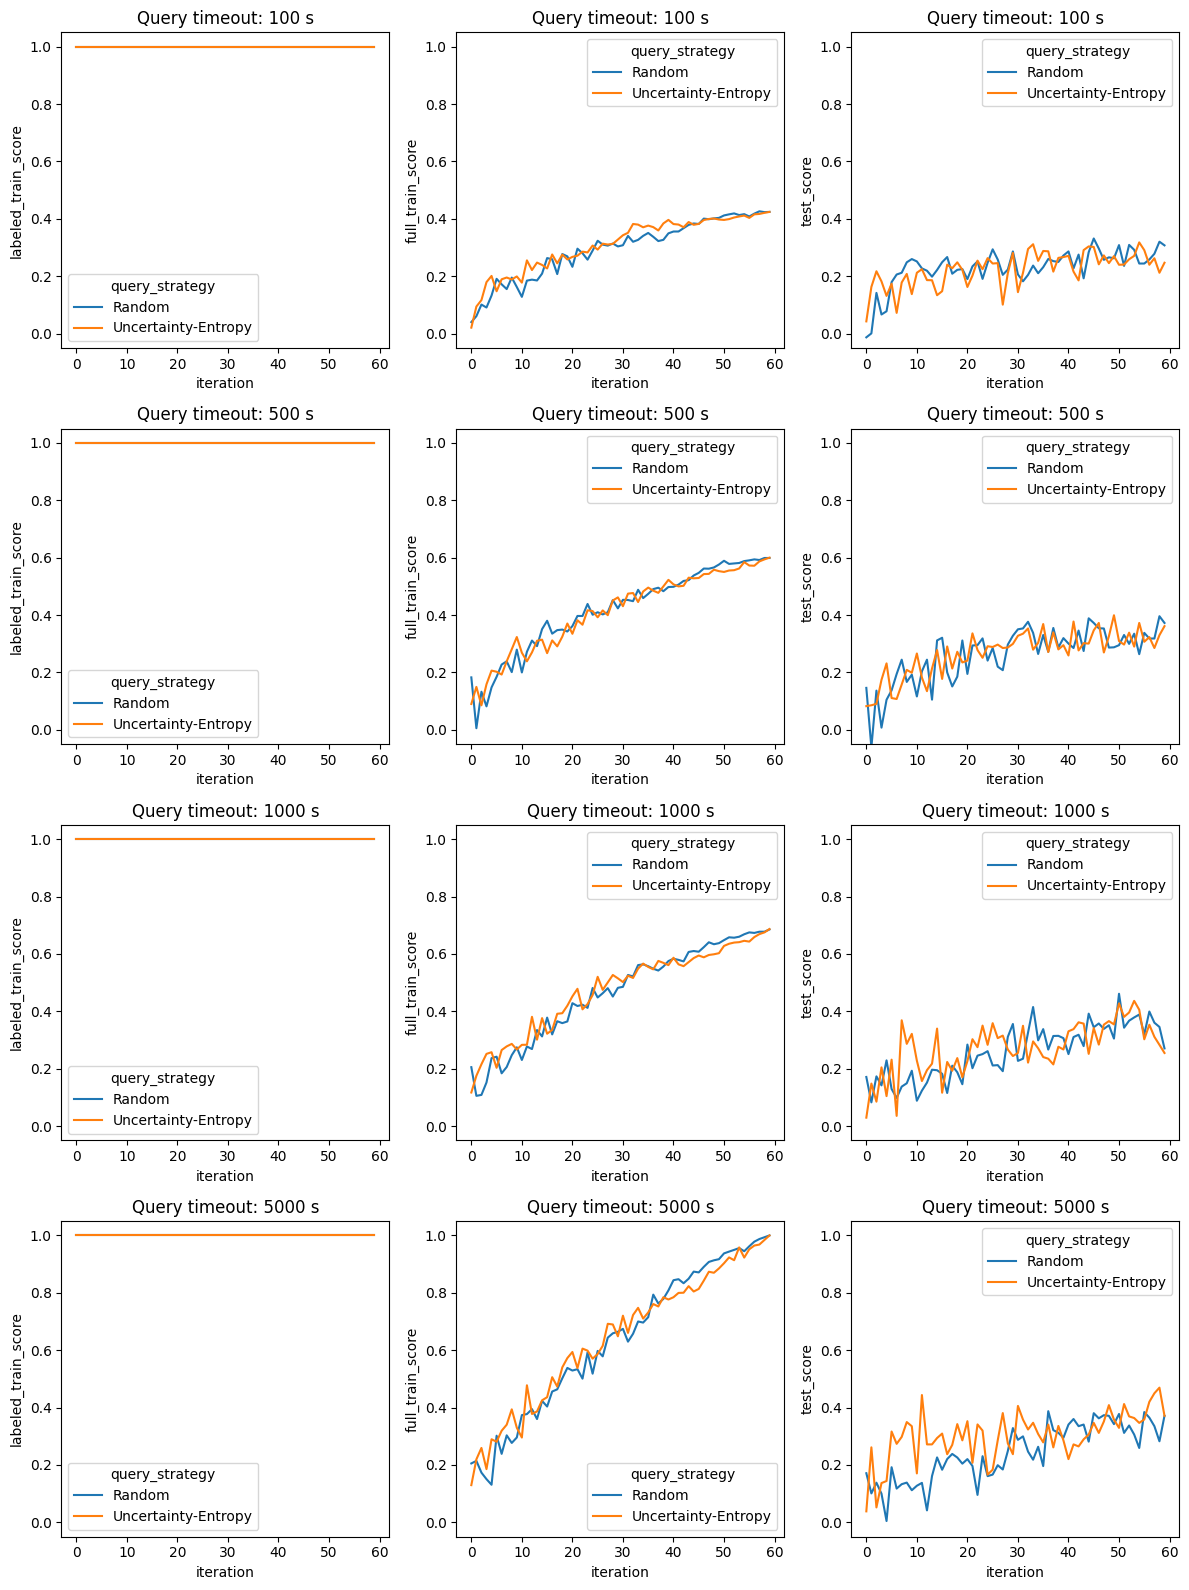

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

_, ax = plt.subplots(figsize=(12, 4 * len(QUERY_TIMEOUTS)), ncols=3, nrows=len(QUERY_TIMEOUTS))
for i, query_timeout in enumerate(QUERY_TIMEOUTS):
    for j, metric in enumerate(['labeled_train_score', 'full_train_score', 'test_score']):
        sns.lineplot(data=results[results['query_timeout'] == query_timeout], x='iteration',
                     y=metric, hue='query_strategy', ax=ax[i, j])
        ax[i, j].set_ylim((-0.05, 1.05))
        ax[i, j].set_title(f'Query timeout: {query_timeout} s')
plt.tight_layout()
plt.show()

On the labeled training data, decision trees make perfect predictions.
On the full training data, a higher query timeout clearly seems beneficial,
while the picture is less clear on the test set.

Let's compare the performance over cost rather than iterations now:

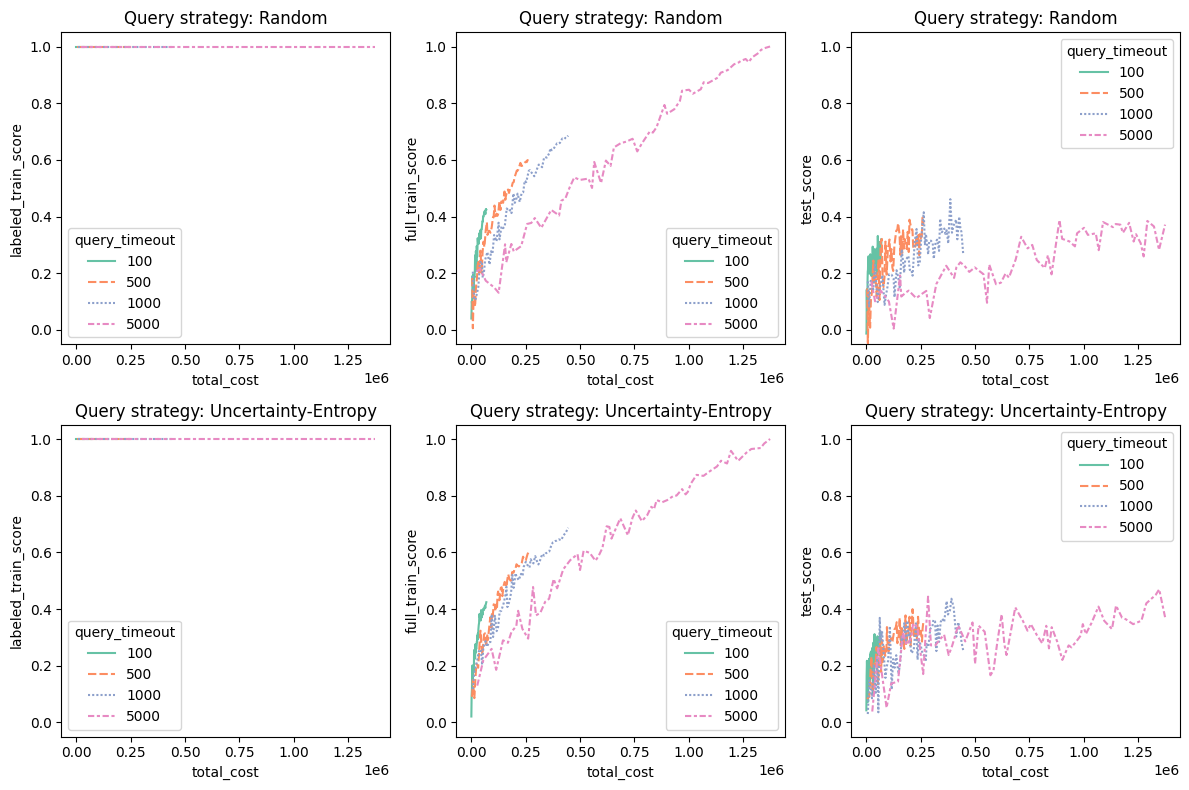

In [6]:
_, ax = plt.subplots(figsize=(12, 4 * len(QUERY_STRATEGIES)), ncols=3, nrows=len(QUERY_STRATEGIES))
for i, query_strategy in enumerate(QUERY_STRATEGIES.keys()):
    for j, metric in enumerate(['labeled_train_score', 'full_train_score', 'test_score']):
        sns.lineplot(data=results[results['query_strategy'] == query_strategy], x='total_cost',
                     y=metric, hue='query_timeout', style='query_timeout', 
                     palette='Set2', ax=ax[i, j])
        # ax[i, j].set_xlim((-1, 100000))  # for "zooming in"
        ax[i, j].set_ylim((-0.05, 1.05))
        ax[i, j].set_title(f'Query strategy: {query_strategy}')
plt.tight_layout()
plt.show()

Smaller query timeouts seem to be more cost-efficient.